# Experiments with Similarity Encoders
## ...to show that SimEc can preserve non-metric similarities
In this iPython Notebook are some examples to illustrate the potential of Similarity Encoders (SimEc) for creating similarity preserving embeddings. For further details and theoretical background on this new neural network architecture, please refer to [the corresponding paper](http://arxiv.org/abs/1702.01824).

In [1]:
from glob import glob
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
from unidecode import unidecode
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import Ridge
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
tf.set_random_seed(28)
import keras

# find nlputils at https://github.com/cod3licious/nlputils
from nlputils.dict_utils import invert_dict2, select_copy
from nlputils.features import FeatureTransform, features2mat
from nlputils.simmat import compute_K

from utils import get_colors, plot_mnist, plot_mnist2, plot_words, check_embed_match, check_similarity_match
from simec import SimilarityEncoder, center_K

%matplotlib inline
%load_ext autoreload
%autoreload 2
# set this to True if you want to save the figures from the paper
savefigs = True

Using TensorFlow backend.


## Proof of Concept
with toy data taken from http://www.jmlr.org/papers/volume5/laub04a/laub04a.pdf

In [2]:
# feature 1: clusters 1:4 and 5:8
D1 = np.array([[0.00, 2.36, 2.59, 1.78, 4.74, 4.82, 4.98, 4.72],
               [2.36, 0.00, 2.39, 1.60, 4.98, 5.06, 5.22, 4.96],
               [2.59, 2.39, 0.00, 2.09, 5.29, 5.37, 5.53, 5.27],
               [1.78, 1.60, 2.09, 0.00, 5.08, 5.16, 5.32, 5.06],
               [4.74, 4.98, 5.29, 5.08, 0.00, 1.20, 1.82, 1.62],
               [4.82, 5.06, 5.37, 5.16, 1.20, 0.00, 2.98, 1.78],
               [4.98, 5.22, 5.53, 5.32, 1.82, 2.98, 0.00, 2.02],
               [4.72, 4.96, 5.27, 5.06, 1.62, 1.78, 2.02, 0.00]])
# feature 2: clusters evens & odds
D2 = np.array([[0.00, 4.15, 2.03, 4.14, 1.26, 4.33, 0.69, 4.85],
               [4.15, 0.00, 4.70, 0.57, 4.37, 1.82, 4.24, 2.02],
               [2.03, 4.70, 0.00, 4.69, 1.85, 4.88, 1.68, 5.40],
               [4.14, 0.57, 4.69, 0.00, 4.36, 1.83, 4.23, 2.67],
               [1.26, 4.37, 1.85, 4.36, 0.00, 4.55, 0.73, 5.07],
               [4.33, 1.82, 4.88, 1.83, 4.55, 0.00, 4.42, 2.14],
               [0.69, 4.24, 1.68, 4.23, 0.73, 4.42, 0.00, 4.94],
               [4.85, 2.02, 5.40, 2.67, 5.07, 2.14, 4.94, 0.00]])
# combined dissimilarity matrix: D1-D2 and transform into similarities
S = -0.5*(D1-D2)

[  6.13892284e+00   9.31076445e-01   6.03175455e-01   2.37120876e-01
   8.24275234e-16  -1.86109044e-01  -3.81796102e-01  -5.69489047e+00]


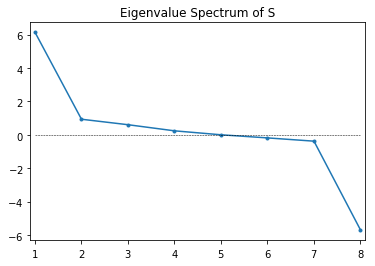

In [3]:
# center
S = center_K(S)
# check out the eigenvalue spectrum - we've got some significant negative eigenvalues!!
eigenvals = np.linalg.eigvalsh(S)[::-1]
print eigenvals
plt.figure();
plt.plot(range(1, S.shape[0]+1), eigenvals, '-o', markersize=3);
plt.plot([1, S.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(0.9, S.shape[0]+0.1);
plt.title('Eigenvalue Spectrum of S');
if savefigs: plt.savefig('fig_nonmetric_toy_evspec.pdf', dpi=300)

In [4]:
# compute embedding based on eigenvalues and -vectors
D, V = np.linalg.eig(S)
D, V = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V.real, np.diag(np.sqrt(np.abs(D.real))))

In [5]:
def plot_8(X, labels):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    for i, l in enumerate(labels):
        plt.text(X[i, 0], X[i, 1], str(l),
                 color='k', fontdict={'weight': 'medium', 'size': 16})
    plt.xticks([]), plt.yticks([])
    plt.xlim(-0.15, 1.15)
    plt.ylim(-0.15, 1.15)

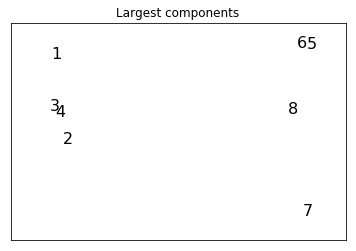

In [6]:
plot_8(X_embed[:,:2], range(1, 9))
plt.title('Largest components');
if savefigs: plt.savefig('fig_nonmetric_toy_largest.pdf', dpi=300)

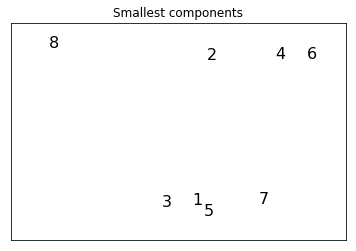

In [7]:
plot_8(X_embed[:,-2:], range(1, 9))
plt.title('Smallest components');
if savefigs: plt.savefig('fig_nonmetric_toy_smallest.pdf', dpi=300)

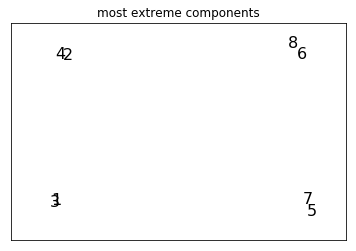

In [8]:
plot_8(X_embed[:,[0,-1]], range(1, 9))
plt.title('most extreme components');

In [9]:
# data: 1 hot encoding
X = np.zeros((8,8))
np.fill_diagonal(X, 1)
# embed with simec
simec = SimilarityEncoder(X.shape[1], 2, S.shape[1], opt=keras.optimizers.Adamax(lr=0.05))
simec.fit(X, S, epochs=70)
X_embed_se = simec.transform(X)

Epoch 1/70
8/8 [==============================] - 0s 60ms/step - loss: 1.0930
Epoch 2/70
8/8 [==============================] - 0s 362us/step - loss: 1.0590
Epoch 3/70
8/8 [==============================] - 0s 458us/step - loss: 1.0164
Epoch 4/70
8/8 [==============================] - 0s 325us/step - loss: 0.9715
Epoch 5/70
8/8 [==============================] - 0s 304us/step - loss: 0.9272
Epoch 6/70
8/8 [==============================] - 0s 323us/step - loss: 0.8835
Epoch 7/70
8/8 [==============================] - 0s 316us/step - loss: 0.8412
Epoch 8/70
8/8 [==============================] - 0s 360us/step - loss: 0.8007
Epoch 9/70
8/8 [==============================] - 0s 317us/step - loss: 0.7585
Epoch 10/70
8/8 [==============================] - 0s 283us/step - loss: 0.7204
Epoch 11/70
8/8 [==============================] - 0s 336us/step - loss: 0.6832
Epoch 12/70
8/8 [==============================] - 0s 319us/step - loss: 0.6464
Epoch 13/70
8/8 [==============================] -

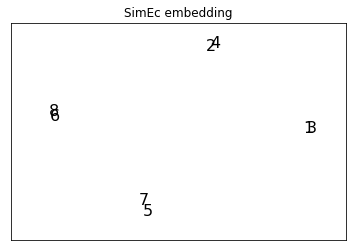

In [10]:
plot_8(X_embed_se, range(1, 9))
plt.title('SimEc embedding');
if savefigs: plt.savefig('fig_nonmetric_toy_simec.pdf', dpi=300)

## Simpson Similarity of 0 and 7 Handwritten Digits

In [11]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X_org = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# only use 0 and 7
X_org = X_org[(y==0)|(y==7),:]
y = y[(y==0)|(y==7)]
X = np.array(X_org>=0.5, dtype=int)  # binarize
# randomly subsample 5000 and split in train/test
np.random.seed(42)
n_samples = 5000
n_test = 1000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X_test, X_test_org, y_test = X[rnd_idx[:n_test],:], X_org[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, X_org, y = X[rnd_idx[n_test:],:], X_org[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]
n_train, n_features = X.shape

In [12]:
# compute simpson similarity
# s_ij = sum(a==1 & b==1)/min(sum(a==1),sum(b==1))
sum_one = np.tile(np.sum(X, axis=1),(X.shape[0],1))
S = np.dot(X, X.T)/np.minimum(sum_one, sum_one.T, dtype=float)
# center
S = center_K(S)
# same for test data
sum_one = np.tile(np.sum(X_test, axis=1),(X_test.shape[0],1))
S_test = np.dot(X_test, X_test.T)/np.minimum(sum_one, sum_one.T, dtype=float)
# center
S_test = center_K(S_test)

[ 424.91268886  189.27935752  172.4782423   122.81287236   98.01329024
   89.98108807   75.1760956    62.296041     51.02963291   48.59421388]
[  -7.48987197   -7.97829788  -10.34106178  -11.54449891  -12.60934772
  -12.93988029  -17.54817457  -27.90307842  -59.33843639 -104.36129652]


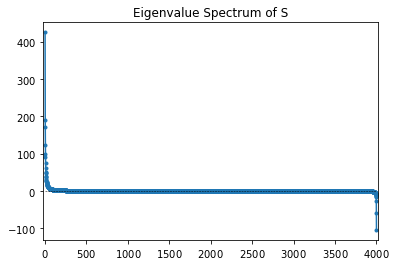

In [13]:
# check out the eigenvalue spectrum - we've got some significant negative eigenvalues!!
eigenvals = np.linalg.eigvalsh(S)[::-1]
print eigenvals[:10]
print eigenvals[-10:]
plt.figure();
plt.plot(range(1, S.shape[0]+1), eigenvals, '-o', markersize=3);
plt.plot([1,S.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(-25, S.shape[0]+15);
plt.title('Eigenvalue Spectrum of S');
if savefigs: plt.savefig('fig_nonmetric_mnist07_evspec.pdf', dpi=300)

### Embedding based on EV

In [14]:
# compute embedding based on eigenvalues and -vectors
D, V = np.linalg.eig(S)
# regular kpca embedding: take largest EV
D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed_largest = np.dot(V1, np.diag(np.sqrt(np.abs(D1))))
# feature discovery: based on absolute value of EV, i.e. also take most negative
D2, V2 = D[np.argsort(np.abs(D))[::-1]], V[:,np.argsort(np.abs(D))[::-1]]
X_embed_abs = np.dot(V2, np.diag(np.sqrt(np.abs(D2))))
# to approximate S, dimensions belonging to negative EV need to be imaginary
X_embed_abs_imag = np.array(np.dot(V2, np.diag(np.sqrt(np.abs(D2)))), dtype=complex)
X_embed_abs_imag[:, D2 < 0] *= 1j

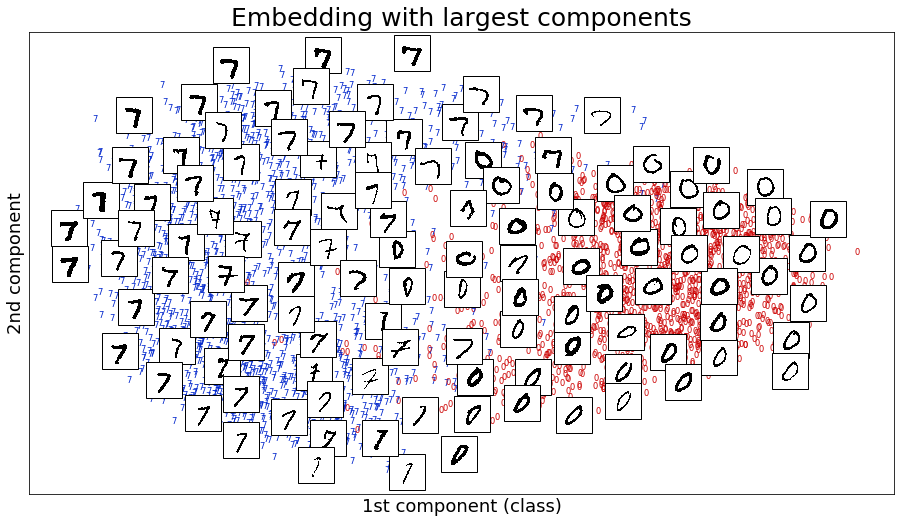

In [15]:
# plot largest
plot_mnist2(X_embed_largest[:,:2], y, X_original=X, title='Embedding with largest components')
plt.xlabel('1st component (class)', fontsize=18);
plt.ylabel('2nd component', fontsize=18);
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)
if savefigs: plt.savefig('fig_nonmetric_mnist07_largest.png', dpi=300)

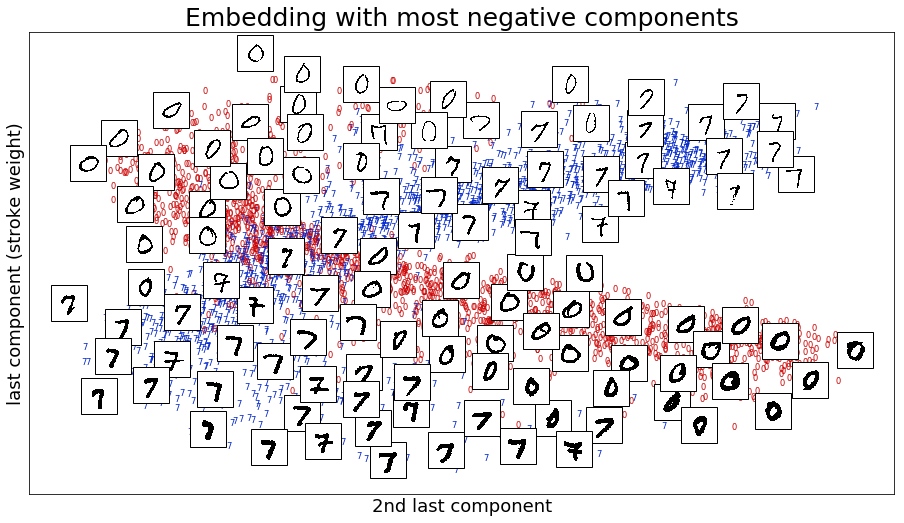

In [16]:
# plot smallest
plot_mnist2(X_embed_largest[:,-2:], y, X_original=X, title='Embedding with most negative components')
plt.xlabel('2nd last component', fontsize=18);
plt.ylabel('last component (stroke weight)', fontsize=18);
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)
if savefigs: plt.savefig('fig_nonmetric_mnist07_smallest.png', dpi=300)

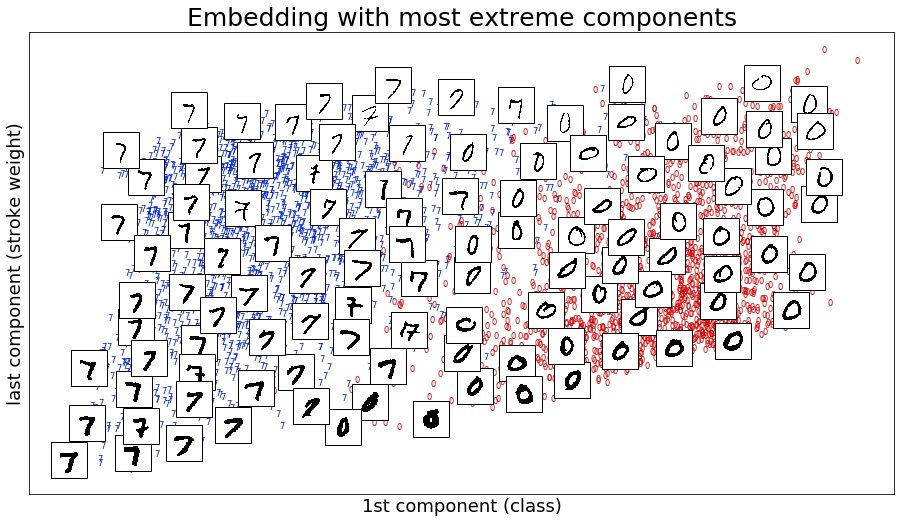

In [17]:
# plot most extreme
plot_mnist2(X_embed_largest[:,[0,-1]], y, X_original=X, title='Embedding with most extreme components')
plt.xlabel('1st component (class)', fontsize=18);
plt.ylabel('last component (stroke weight)', fontsize=18);
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)

In [18]:
# inspect similarity matrix: it's a combination of two simmats 
# S1 based on positive EV
S1 = np.dot(X_embed_largest[:, D1>=0], X_embed_largest[:, D1>=0].T)
# and S2 based on negative EV
S2 = np.dot(X_embed_largest[:, D1<0], X_embed_largest[:, D1<0].T)
S1pS2 = S1 + S2
print "S = S1-S2: %r " % np.allclose(S, S1-S2)
# with the embeddings based on EV without imaginary parts, we approximate S1+S2
print "X_embed_largest*X_embed_largest^T = S1+S2 : %r" % np.allclose(S1pS2, np.dot(X_embed_largest, X_embed_largest.T))
print "X_embed_abs*X_embed_abs^T = S1+S2 : %r" % np.allclose(S1pS2, np.dot(X_embed_abs, X_embed_abs.T))
# while with the embeddings where the negative EV are represented as imaginary numbers.
# we can approximate the real S (i.e. S1-S2)
print "X_embed_abs_imag*X_embed_abs_imag^T = S1-S2 : %r" % np.allclose(S1-S2, np.dot(X_embed_abs_imag, X_embed_abs_imag.T))

S = S1-S2: True 
X_embed_largest*X_embed_largest^T = S1+S2 : True
X_embed_abs*X_embed_abs^T = S1+S2 : True
X_embed_abs_imag*X_embed_abs_imag^T = S1-S2 : True


2 . . 10 . . 50 . . 100 . . 200 . . 1000 . . 2000 . . 3000 . . 3800 . . 3900 . . 3950 . . 3990 . . 4000 . .


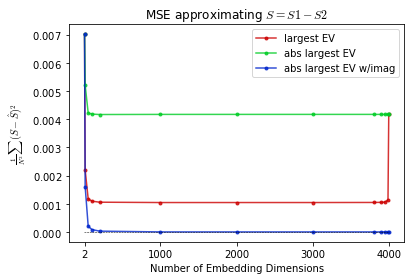

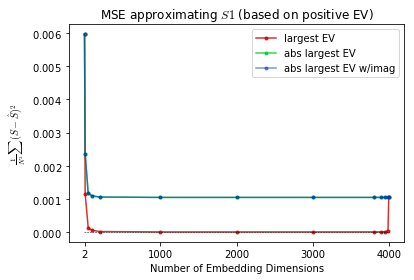

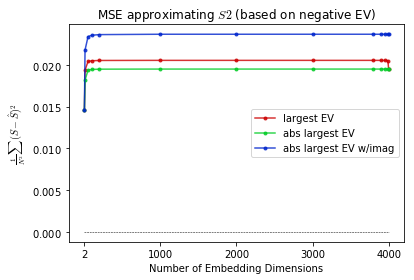

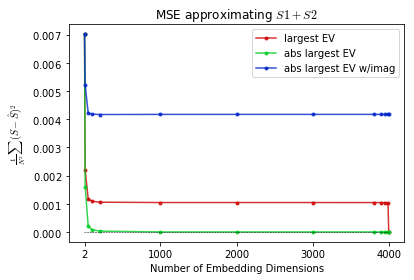

In [19]:
# let's see how well S1, S1+S2, and S1-S2 are approximated
# depending on the number of embedding dimensions
colors = get_colors(10)
mseS_largest, mseS_abs, mseS_abs_imag = [], [], []
mseS1_largest, mseS1_abs, mseS1_abs_imag = [], [], []
mseS2_largest, mseS2_abs, mseS2_abs_imag = [], [], []
mseS1pS2_largest, mseS1pS2_abs, mseS1pS2_abs_imag = [], [], []
e_dims = [2, 10, 50, 100, 200, 1000, 2000, 3000, 3800, 3900, 3950, 3990, S.shape[0]]
for e_dim in e_dims:
    print e_dim,
    # largest components
    S_approx = np.dot(X_embed_largest[:,:e_dim], X_embed_largest[:,:e_dim].T)
    mseS_largest.append(check_similarity_match(S_approx, S, True)[0])
    mseS1_largest.append(check_similarity_match(S_approx, S1, True)[0])
    mseS2_largest.append(check_similarity_match(S_approx, S2, True)[0])
    mseS1pS2_largest.append(check_similarity_match(S_approx, S1pS2, True)[0])
    print ".",
    # largest components based on absolute ev
    S_approx = np.dot(X_embed_abs[:,:e_dim], X_embed_abs[:,:e_dim].T)
    mseS_abs.append(check_similarity_match(S_approx, S, True)[0])
    mseS1_abs.append(check_similarity_match(S_approx, S1, True)[0])
    mseS2_abs.append(check_similarity_match(S_approx, S2, True)[0])
    mseS1pS2_abs.append(check_similarity_match(S_approx, S1pS2, True)[0])
    print ".",
    # largest components based on absolute ev with negative ev as imag
    S_approx = np.dot(X_embed_abs_imag[:,:e_dim], X_embed_abs_imag[:,:e_dim].T).real
    mseS_abs_imag.append(check_similarity_match(S_approx, S, True)[0])
    mseS1_abs_imag.append(check_similarity_match(S_approx, S1, True)[0])
    mseS2_abs_imag.append(check_similarity_match(S_approx, S2, True)[0])
    mseS1pS2_abs_imag.append(check_similarity_match(S_approx, S1pS2, True)[0])
plt.figure();
plt.plot(e_dims, mseS_largest, '-o', markersize=3, c=colors[0], alpha=0.8, label='largest EV');
plt.plot(e_dims, mseS_abs, '-o', markersize=3, c=colors[4], alpha=0.8, label='abs largest EV');
plt.plot(e_dims, mseS_abs_imag, '-o', markersize=3, c=colors[7], alpha=0.8, label='abs largest EV w/imag');
plt.legend(loc=0);
plt.title('MSE approximating $S = S1 - S2$');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks([2, 1000, 2000, 3000, 4000], [2, 1000, 2000, 3000, 4000]);
plt.xlabel('Number of Embedding Dimensions');
plt.ylabel(r'$\frac{1}{N^2} \sum ( S-\hat{S} )^2$');
plt.figure();
plt.plot(e_dims, mseS1_largest, '-o', markersize=3, c=colors[0], alpha=0.8, label='largest EV');
plt.plot(e_dims, mseS1_abs, '-o', markersize=3, c=colors[4], alpha=0.8, label='abs largest EV');
plt.plot(e_dims, mseS1_abs_imag, '-o', markersize=3, c=colors[7], alpha=0.5, label='abs largest EV w/imag');
plt.legend(loc=0);
plt.title('MSE approximating $S1$ (based on positive EV)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks([2, 1000, 2000, 3000, 4000], [2, 1000, 2000, 3000, 4000]);
plt.xlabel('Number of Embedding Dimensions');
plt.ylabel(r'$\frac{1}{N^2} \sum ( S-\hat{S} )^2$');
plt.figure();
plt.plot(e_dims, mseS2_largest, '-o', markersize=3, c=colors[0], alpha=0.8, label='largest EV');
plt.plot(e_dims, mseS2_abs, '-o', markersize=3, c=colors[4], alpha=0.8, label='abs largest EV');
plt.plot(e_dims, mseS2_abs_imag, '-o', markersize=3, c=colors[7], alpha=0.8, label='abs largest EV w/imag');
plt.legend(loc=0);
plt.title('MSE approximating $S2$ (based on negative EV)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks([2, 1000, 2000, 3000, 4000], [2, 1000, 2000, 3000, 4000]);
plt.xlabel('Number of Embedding Dimensions');
plt.ylabel(r'$\frac{1}{N^2} \sum ( S-\hat{S} )^2$');
plt.figure();
plt.plot(e_dims, mseS1pS2_largest, '-o', markersize=3, c=colors[0], alpha=0.8, label='largest EV');
plt.plot(e_dims, mseS1pS2_abs, '-o', markersize=3, c=colors[4], alpha=0.8, label='abs largest EV');
plt.plot(e_dims, mseS1pS2_abs_imag, '-o', markersize=3, c=colors[7], alpha=0.8, label='abs largest EV w/imag');
plt.legend(loc=0);
plt.title('MSE approximating $S1 + S2$');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks([2, 1000, 2000, 3000, 4000], [2, 1000, 2000, 3000, 4000]);
plt.xlabel('Number of Embedding Dimensions');
plt.ylabel(r'$\frac{1}{N^2} \sum ( S-\hat{S} )^2$');

### Embedding with Ridge Regression

In [20]:
# adapt the input data
ss = StandardScaler(with_std=False)
X_tf = ss.fit_transform(X_org)
X_test_tf = ss.transform(X_test_org)

mse ridgereg: 0.002598
with kPCA: mse: 0.004777; r^2: 0.835106; rho: 0.897065
with CS  : mse: 0.002591; r^2: 0.879322; rho: 0.919249


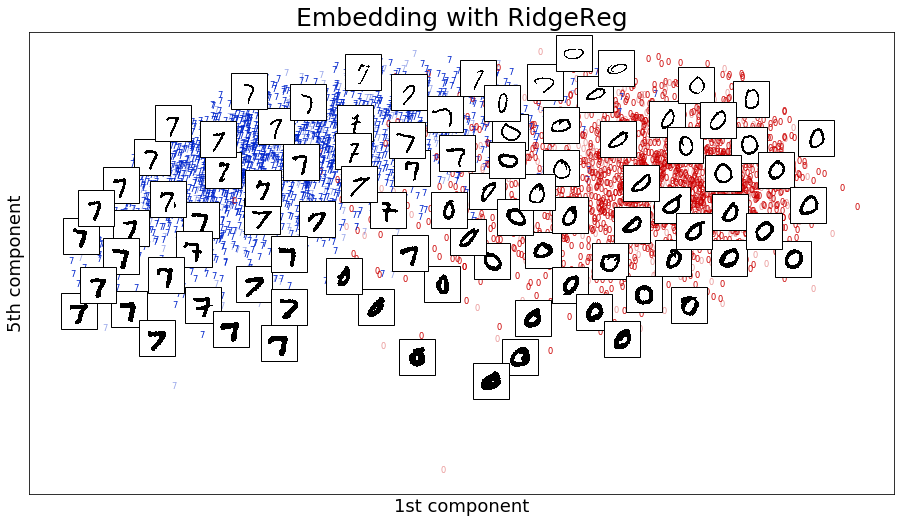

In [21]:
# ridge reg
model = Ridge()
model.fit(X_tf, X_embed_abs[:,:10])
X_embed_r = model.predict(X_tf)
X_embed_test_r = model.predict(X_test_tf)
mse, rsq, _ = check_similarity_match(X_embed_r, S1pS2)
print "mse ridgereg: %f" % mse
print "with kPCA: mse: %f; r^2: %f; rho: %f" % check_embed_match(X_embed_largest[:,:10], X_embed_r)
print "with CS  : mse: %f; r^2: %f; rho: %f" % check_embed_match(X_embed_abs[:,:10], X_embed_r)
plot_mnist2(X_embed_r[:,[0,4]], y, X_embed_test_r[:,[0,4]], y_test, X_original=X, title='Embedding with RidgeReg')
plt.xlabel('1st component', fontsize=18);
plt.ylabel('5th component', fontsize=18);
fig = plt.gcf();
fig.set_size_inches(15.5, 8.5);

### Embedding with SimEc

In [22]:
# create embedding with simec
n_targets = 1000
simec = SimilarityEncoder(X_tf.shape[1], 10, n_targets, hidden_layers=[(200, 'tanh')],
                              l2_reg=0.0000001, l2_reg_emb=0.0001, l2_reg_out=0.0000001, 
                              s_ll_reg=0.5, S_ll=S1pS2[:n_targets,:n_targets],
                              opt=keras.optimizers.Adamax(lr=0.0008))
simec.fit(X_tf, S[:, :n_targets])
X_embed = simec.transform(X_tf)
X_embed_test = simec.transform(X_test_tf)
mse, rsq, _ = check_similarity_match(X_embed, S1pS2)
print "mse simec: %f" % mse
print "with kPCA: mse: %f; r^2: %f; rho: %f" % check_embed_match(X_embed_largest[:,:10], X_embed)
print "with CS  : mse: %f; r^2: %f; rho: %f" % check_embed_match(X_embed_abs[:,:10], X_embed)

Epoch 1/25
4000/4000 [==============================] - 1s 158us/step - loss: 0.0249
Epoch 2/25
4000/4000 [==============================] - 0s 112us/step - loss: 0.0178
Epoch 3/25
4000/4000 [==============================] - 0s 114us/step - loss: 0.0158
Epoch 4/25
4000/4000 [==============================] - 0s 108us/step - loss: 0.0144
Epoch 5/25
4000/4000 [==============================] - 0s 113us/step - loss: 0.0129
Epoch 6/25
4000/4000 [==============================] - 0s 110us/step - loss: 0.0113
Epoch 7/25
4000/4000 [==============================] - 0s 116us/step - loss: 0.0094
Epoch 8/25
4000/4000 [==============================] - 0s 112us/step - loss: 0.0078
Epoch 9/25
4000/4000 [==============================] - 0s 113us/step - loss: 0.0066
Epoch 10/25
4000/4000 [==============================] - 0s 114us/step - loss: 0.0058
Epoch 11/25
4000/4000 [==============================] - 0s 114us/step - loss: 0.0051
Epoch 12/25
4000/4000 [==============================] - 0s 113

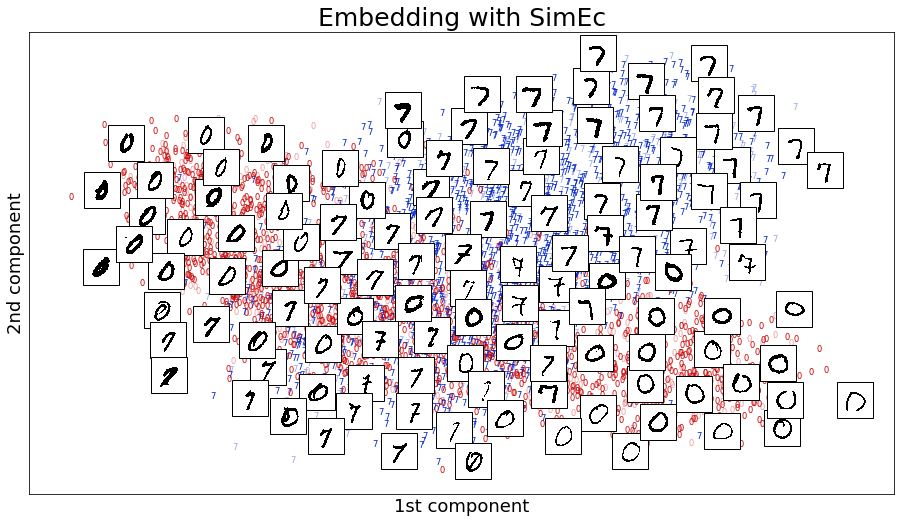

In [23]:
plot_mnist2(X_embed[:,:2], y, X_embed_test[:,:2], y_test, X_original=X, title='Embedding with SimEc')
plt.xlabel('1st component', fontsize=18);
plt.ylabel('2nd component', fontsize=18);
fig = plt.gcf();
fig.set_size_inches(15.5, 8.5);

In [24]:
# we need to decorrelate the simec embedding to find what we're looking for
pca = PCA(n_components=10)
X_embed_pca = pca.fit_transform(X_embed)
X_embed_test_pca = pca.transform(X_embed_test)

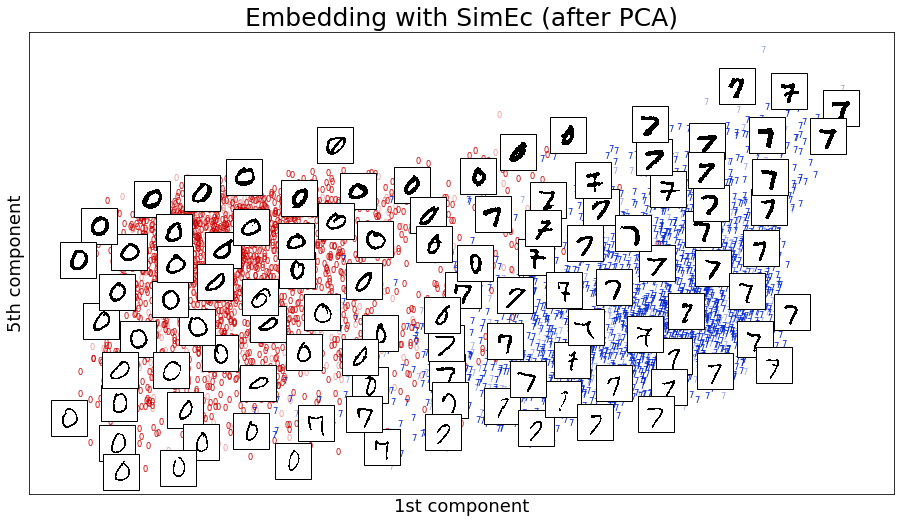

In [25]:
plot_mnist2(X_embed_pca[:,[0,4]], y, X_embed_test_pca[:,[0,4]], y_test, X_original=X, title='Embedding with SimEc (after PCA)')
plt.xlabel('1st component', fontsize=18);
plt.ylabel('5th component', fontsize=18);
fig = plt.gcf();
fig.set_size_inches(15.5, 8.5);
if savefigs: plt.savefig('fig_nonmetric_mnist07_simec_pca.png', dpi=300)

2
Epoch 1/25
4000/4000 [==============================] - 1s 165us/step - loss: 0.0267
Epoch 2/25
4000/4000 [==============================] - 0s 114us/step - loss: 0.0202
Epoch 3/25
4000/4000 [==============================] - 0s 120us/step - loss: 0.0194
Epoch 4/25
4000/4000 [==============================] - 0s 120us/step - loss: 0.0184
Epoch 5/25
4000/4000 [==============================] - 0s 118us/step - loss: 0.0177
Epoch 6/25
4000/4000 [==============================] - 0s 110us/step - loss: 0.0173
Epoch 7/25
4000/4000 [==============================] - 0s 113us/step - loss: 0.0170
Epoch 8/25
4000/4000 [==============================] - 0s 109us/step - loss: 0.0167
Epoch 9/25
4000/4000 [==============================] - 0s 113us/step - loss: 0.0162
Epoch 10/25
4000/4000 [==============================] - 0s 117us/step - loss: 0.0156
Epoch 11/25
4000/4000 [==============================] - 0s 116us/step - loss: 0.0148
Epoch 12/25
4000/4000 [==============================] - 0s 1

4000/4000 [==============================] - 0s 119us/step - loss: 0.0015
Epoch 20/25
4000/4000 [==============================] - 0s 120us/step - loss: 0.0014
Epoch 21/25
4000/4000 [==============================] - 0s 122us/step - loss: 0.0013
Epoch 22/25
4000/4000 [==============================] - 0s 122us/step - loss: 0.0012
Epoch 23/25
4000/4000 [==============================] - 0s 116us/step - loss: 0.0012
Epoch 24/25
4000/4000 [==============================] - 0s 119us/step - loss: 0.0011
Epoch 25/25
4000/4000 [==============================] - 0s 119us/step - loss: 0.0011
mse kpca: 0.001170 , mse cs: 0.000200; mse ridge: 0.001415; mse simec: 0.001051
ridge with kPCA: mse: 0.003511; r^2: 0.761512; rho: 0.820127
ridge with CS  : mse: 0.003374; r^2: 0.756737; rho: 0.816613
simec with kPCA: mse: 0.002214; r^2: 0.826555; rho: 0.887284
simec with CS  : mse: 0.001919; r^2: 0.844091; rho: 0.891911
100
Epoch 1/25
4000/4000 [==============================] - 1s 208us/step - loss: 0.03

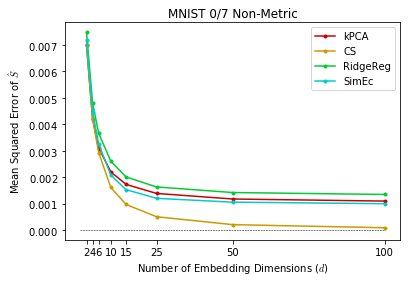

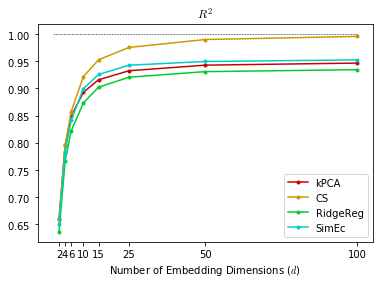

In [26]:
colors = get_colors(15)
mse_kpca, mse_cs, mse_ridge, mse_simec = [], [], [], []
rsq_kpca, rsq_cs, rsq_ridge, rsq_simec = [], [], [], []
e_dims = [2, 4, 6, 10, 15, 25, 50, 100]
for e_dim in e_dims:
    print e_dim
    # kpca: take only largest components
    mse_k, rsq, _ = check_similarity_match(X_embed_largest[:,:e_dim], S1pS2)
    mse_kpca.append(mse_k)
    rsq_kpca.append(rsq)
    # classical scaling: take only largest components based on absolute ev
    mse_c, rsq, _ = check_similarity_match(X_embed_abs[:,:e_dim], S1pS2)
    mse_cs.append(mse_c)
    rsq_cs.append(rsq)
    # ridge reg
    model = Ridge()
    model.fit(X_tf, X_embed_abs[:,:e_dim])
    X_embed_r = model.predict(X_tf)
    mse_r, rsq, _ = check_similarity_match(X_embed_r, S1pS2)
    mse_ridge.append(mse_r)
    rsq_ridge.append(rsq)
    # simec
    simec = SimilarityEncoder(X_tf.shape[1], e_dim, n_targets, hidden_layers=[(200, 'tanh')],
                              l2_reg=0.0000001, l2_reg_emb=0.0001, l2_reg_out=0.0000001, 
                              s_ll_reg=0.5, S_ll=S1pS2[:n_targets,:n_targets],
                              opt=keras.optimizers.Adamax(lr=0.0008))
    simec.fit(X_tf, S[:, :n_targets])
    X_embed = simec.transform(X_tf)
    mse, rsq, _ = check_similarity_match(X_embed, S1pS2)
    mse_simec.append(mse)
    rsq_simec.append(rsq)
    print "mse kpca: %f , mse cs: %f; mse ridge: %f; mse simec: %f" % (mse_k, mse_c, mse_r, mse)
    print "ridge with kPCA: mse: %f; r^2: %f; rho: %f" % check_embed_match(X_embed_largest[:,:e_dim], X_embed_r)
    print "ridge with CS  : mse: %f; r^2: %f; rho: %f" % check_embed_match(X_embed_abs[:,:e_dim], X_embed_r)
    print "simec with kPCA: mse: %f; r^2: %f; rho: %f" % check_embed_match(X_embed_largest[:,:e_dim], X_embed)
    print "simec with CS  : mse: %f; r^2: %f; rho: %f" % check_embed_match(X_embed_abs[:,:e_dim], X_embed)
plt.figure();
plt.plot(e_dims, mse_kpca, '-o', markersize=3, c=colors[0], label='kPCA');
plt.plot(e_dims, mse_cs, '-o', markersize=3, c=colors[2], label='CS');
plt.plot(e_dims, mse_ridge, '-o', markersize=3, c=colors[6], label='RidgeReg');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.legend(loc=0);
plt.title('MNIST 0/7 Non-Metric');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)');
plt.ylabel('Mean Squared Error of $\hat{S}$');
plt.figure();
plt.plot(e_dims, rsq_kpca, '-o', markersize=3, c=colors[0], label='kPCA');
plt.plot(e_dims, rsq_cs, '-o', markersize=3, c=colors[2], label='CS');
plt.plot(e_dims, rsq_ridge, '-o', markersize=3, c=colors[6], label='RidgeReg');
plt.plot(e_dims, rsq_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.legend(loc=0);
plt.title('$R^2$');
plt.plot([0, e_dims[-1]], [1,1], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)');

## Similarities of Words from Grimm's Fairy Tales and NASA News

#### load grimm's fairy tales and nasa news articles

In [27]:
# get 62 grimm fairy tales
# originally from https://www.gutenberg.org/files/2591/2591-0.txt
# but removing beginning and end and fixing a few newlines
with open('data/nonmetric/grimm_all.txt') as f:
    grimm = f.read()
grimm = unidecode(grimm.decode('utf8'))
grimm = grimm.replace('\r','')
grimm = grimm.split('\n\n\n\n\n')
grimm = [g.replace('\n', ' ') for g in grimm]
n_words = [len(g.split()) for g in grimm]
print "%i fairy tales with %i - %i words" % (len(grimm), min(n_words), max(n_words))

62 fairy tales with 255 - 3793 words


In [28]:
# get 62 nasa news articles from 2002
# originally from here: https://www.nasa.gov/audience/formedia/archives/MP_Archive_02.html
nasa = []
for fname in glob('data/nonmetric/nasa/*.txt'):
    with open(fname) as f:
        nasa.append(unidecode(f.read().decode('utf8')).replace('\r',''))
nasa = [n.replace('\n', ' ') for n in nasa]
n_words = [len(n.split()) for n in nasa]    
print "%i news articles with %i - %i words" % (len(nasa), min(n_words), max(n_words))

62 news articles with 275 - 1032 words


#### transform the texts into features and select frequent words

In [29]:
# transform into dictionaries for nlputils
grimm = {'grimm %i'%i:g for i, g in enumerate(grimm, 1)}
nasa = {'nasa %i'%i:n for i, n in enumerate(nasa, 1)}
# transform into tf features (unweighted!)
ft = FeatureTransform(norm='max', weight=False, renorm=None, identify_bigrams=False, norm_num=False)
grimm_feats = ft.texts2features(grimm)
nasa_feats = ft.texts2features(nasa)

In [30]:
# invert dictionaries to get for every word the number of docs it occurred in
grimm_words = invert_dict2(grimm_feats)
nasa_words = invert_dict2(nasa_feats)
# accumulate the counts to get the most frequent words
grimm_words_acc = {w: sum([grimm_words[w][d] for d in grimm_words[w]]) for w in grimm_words}
nasa_words_acc = {w: sum([nasa_words[w][d] for d in nasa_words[w]]) for w in nasa_words}
print "Grimm's Fairy Tale"
print '\n'.join(sorted(grimm_words_acc, key=grimm_words_acc.get, reverse=True)[200:220])
print "NASA news articles"
print '\n'.join(sorted(nasa_words_acc, key=nasa_words_acc.get, reverse=True)[40:60])
# manually filter and select some of the most frequent words (50 each)
grimm_selected = ['little', 'king', 'away', 'old', 'good', 'man', 'time', 'day', 'home', 'father', 
                  'thought', 'fox', 'last', 'mother', 'cried', 'wife', 'long', 'way', 'nothing', 
                  'door', 'great', 'cat', 'gretel', 'eat', 'head', 'beautiful', 'son', 'house', 
                  'morning', 'water', 'horse', 'child', 'woman', 'wood', 'wolf', 'bird', 'princess', 
                  'tree', 'daughter', 'master', 'night', 'gold', 'forest', 'evening', 'castle', 'heart', 
                  'eyes', 'fire', 'queen', 'bed']
nasa_selected = ['space', 'nasa', 'flight', 'earth', 'phone', 'mission', 'research', 'science', 
                 'washington', 'technology', 'program', 'station', 'data', 'system', 'headquarters', 
                 'information', 'spacecraft', 'first', 'university', 'launch', 'international', 'office', 
                 'shuttle', 'operations', 'agency', 'orbit', 'astronaut', 'atmosphere', 'solar', 'years', 
                 'future', 'missions', 'additional', 'scientists', 'safety', 'national', 'team', 'laboratory', 
                 'scientific', 'internet', 'crew', 'engineers', 'field', 'air', 'software', 'work', 
                 'satellite', 'environment', 'control', 'hubble']

Grimm's Fairy Tale
stood
us
something
children
every
heart
while
through
eyes
fire
hand
look
find
tell
bed
girl
queen
cook
going
world
NASA news articles
data
have
system
headquarters
information
2002
spacecraft
its
release
than
we
202
can
which
about
first
university
available
administrator
also


In [31]:
words_selected = grimm_selected+nasa_selected
#words_selected = ['courtyard','talers','church','fortune','pearls','ravens','sword','thieves','dragon','handsome','princes','cottage','robbers','apples','frog','village','dwarfs','words','moment','ashes','hands','huntsmen','shepherd','grandmother','death','length','word','land','lie','witch','palace','servant','piece','face','kingdom','table','wish','youth','soldier','drink','money','window','master','fine','tailor','cat','wolf','heart','bed','queen','wood','round','castle','fox','poor','house','beautiful','door','man','space','earth','right','all','years','solar','time','shuttle','science','station','other','sun','first','water','astronauts','orbit','mission','image','scientists','research','center','news','way','system','data','planet','long','light','gravity','high','good','radiation','meteor','propulsion','satellite','well','little','comet','people','together','air','work','telescope','day','place','morning','rockets','life','hard','large','energy','old','temperature','robot','engine','end','thing','physics','nuclear','hydrogen','head','cosmic','home','environment','computer','scientist','hand','atoms','night','exploration','body','great','fire','world','tree','forest','eyes','young','sound','country']
# get one dict with the selected words and the documents they occur in to compute their similarities
grimm_feats.update(nasa_feats)
words_dict = select_copy(invert_dict2(grimm_feats), words_selected)
words_selected = words_dict.keys()

In [32]:
# get similarity matrix of words where 
# s_ij = #{docs with i AND j}/#{docs with i OR j}
def compute_rocha_sim(word1_dict, word2_dict):
    s = float(len(set(word1_dict.keys()) & set(word2_dict.keys())))
    if not s:
        return np.finfo(float).eps
    return s/len(set(word1_dict.keys()) | set(word2_dict.keys()))
N = len(words_selected)
S = np.zeros((N, N))
for i, did in enumerate(words_selected):
    for j in range(i + 1):
        similarity = np.log(compute_rocha_sim(words_dict[did], words_dict[words_selected[j]]))
        S[i, j], S[j, i] = similarity, similarity
# center matrix
S /= np.max(np.abs(S))
S = center_K(S)

[ 31.33604797   4.95236018   4.79711511   4.05009333   3.65669978]
[-3.31373975 -3.53055135 -4.10922523 -4.76011161 -7.40005291]


Text(0.5,1,u'Eigenvalue Spectrum of S')

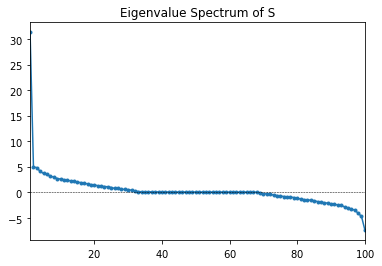

In [33]:
# check out the eigenvalue spectrum - we've got some significant negative eigenvalues!!
eigenvals = np.linalg.eigvalsh(S)[::-1]
print eigenvals[:5]
print eigenvals[-5:]
plt.figure()
plt.plot(range(1, S.shape[0]+1), eigenvals, '-o', markersize=3)
plt.plot([1,S.shape[0]],[0,0], 'k--', linewidth=0.5)
plt.xlim(0, S.shape[0]+1)
plt.title('Eigenvalue Spectrum of S')

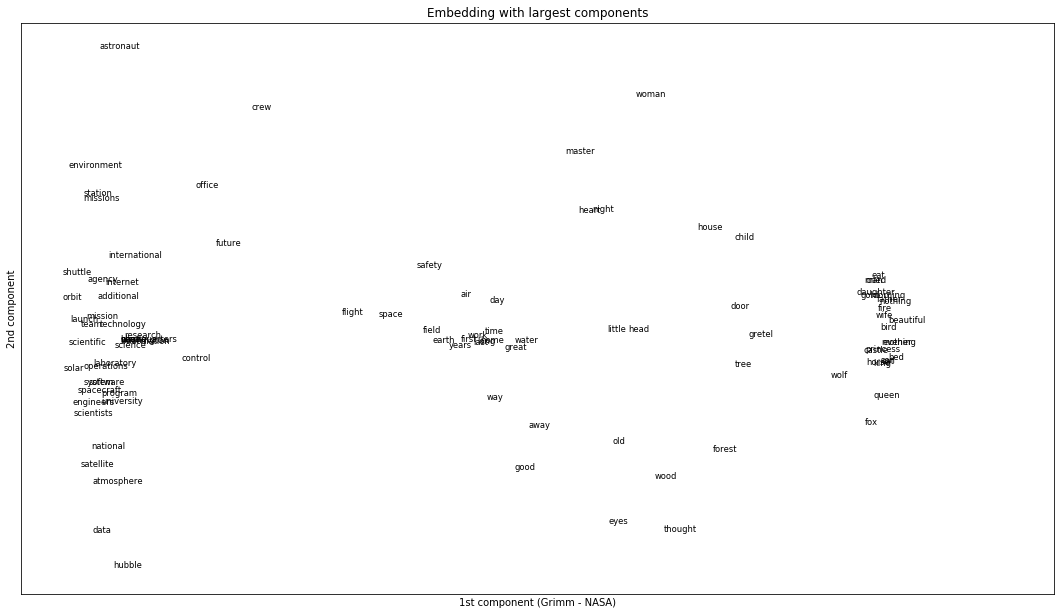

In [34]:
# compute embedding based on eigenvalues and -vectors
D, V = np.linalg.eig(S)  # guard against spurious complex e-vals from roundoff
D, V = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V.real, np.diag(np.sqrt(np.abs(D.real))))
# plot largest
plot_words(X_embed[:,:2], words_selected, 'Embedding with largest components')
plt.xlabel('1st component (Grimm - NASA)');
plt.ylabel('2nd component');
fig = plt.gcf();
fig.set_size_inches(18.5, 10.5);

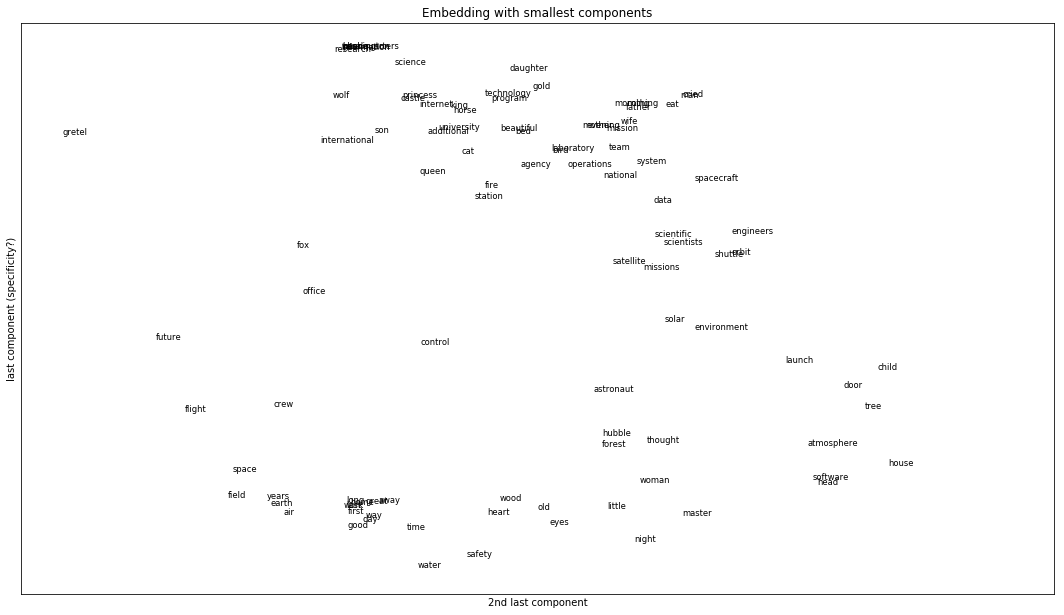

In [35]:
plot_words(X_embed[:,-2:], words_selected, 'Embedding with smallest components')
plt.xlabel('2nd last component');
plt.ylabel('last component (specificity?)');
fig = plt.gcf();
fig.set_size_inches(18.5, 10.5);

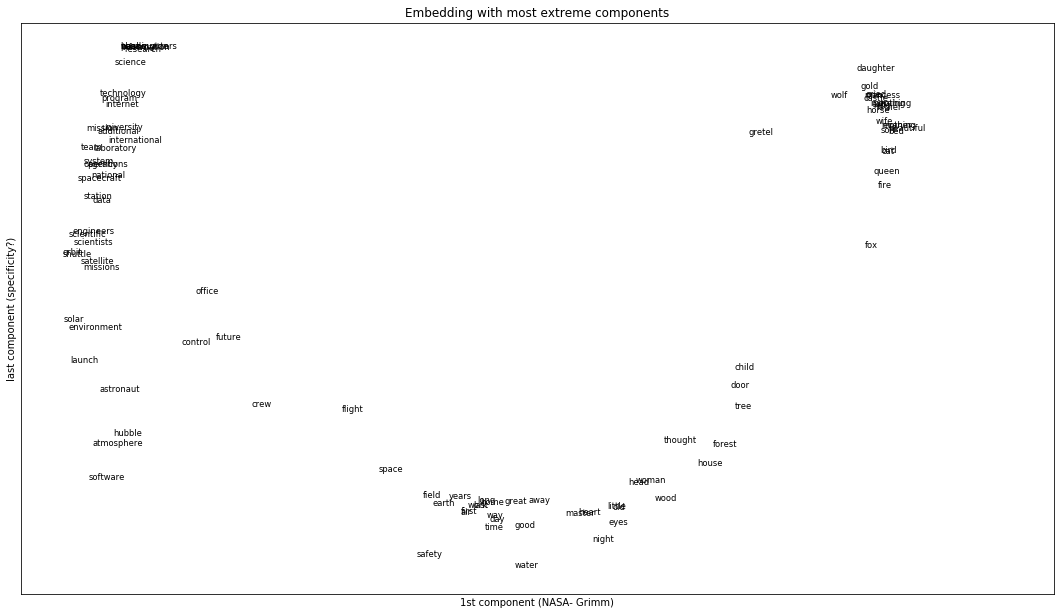

In [36]:
plot_words(X_embed[:,[0,-1]], words_selected, 'Embedding with most extreme components')
plt.xlabel('1st component (NASA- Grimm)');
plt.ylabel('last component (specificity?)');
fig = plt.gcf();
fig.set_size_inches(18.5, 10.5);

Epoch 1/400
100/100 [==============================] - 0s 3ms/step - loss: 0.1358
Epoch 2/400
100/100 [==============================] - 0s 205us/step - loss: 0.1295
Epoch 3/400
100/100 [==============================] - 0s 128us/step - loss: 0.1159
Epoch 4/400
100/100 [==============================] - 0s 150us/step - loss: 0.0999
Epoch 5/400
100/100 [==============================] - 0s 159us/step - loss: 0.0896
Epoch 6/400
100/100 [==============================] - 0s 147us/step - loss: 0.0852
Epoch 7/400
100/100 [==============================] - 0s 145us/step - loss: 0.0784
Epoch 8/400
100/100 [==============================] - 0s 113us/step - loss: 0.0743
Epoch 9/400
100/100 [==============================] - 0s 154us/step - loss: 0.0727
Epoch 10/400
100/100 [==============================] - 0s 115us/step - loss: 0.0709
Epoch 11/400
100/100 [==============================] - 0s 135us/step - loss: 0.0691
Epoch 12/400
100/100 [==============================] - 0s 134us/step - loss

100/100 [==============================] - 0s 159us/step - loss: 0.0344
Epoch 192/400
100/100 [==============================] - 0s 124us/step - loss: 0.0347
Epoch 193/400
100/100 [==============================] - 0s 144us/step - loss: 0.0345
Epoch 194/400
100/100 [==============================] - 0s 174us/step - loss: 0.0343
Epoch 195/400
100/100 [==============================] - 0s 162us/step - loss: 0.0343
Epoch 196/400
100/100 [==============================] - 0s 157us/step - loss: 0.0343
Epoch 197/400
100/100 [==============================] - 0s 132us/step - loss: 0.0343
Epoch 198/400
100/100 [==============================] - 0s 119us/step - loss: 0.0342
Epoch 199/400
100/100 [==============================] - 0s 136us/step - loss: 0.0342
Epoch 200/400
100/100 [==============================] - 0s 136us/step - loss: 0.0343
Epoch 201/400
100/100 [==============================] - 0s 121us/step - loss: 0.0342
Epoch 202/400
100/100 [==============================] - 0s 149us/st

100/100 [==============================] - 0s 156us/step - loss: 0.0330
Epoch 382/400
100/100 [==============================] - 0s 201us/step - loss: 0.0331
Epoch 383/400
100/100 [==============================] - 0s 173us/step - loss: 0.0331
Epoch 384/400
100/100 [==============================] - 0s 131us/step - loss: 0.0331
Epoch 385/400
100/100 [==============================] - 0s 120us/step - loss: 0.0330
Epoch 386/400
100/100 [==============================] - 0s 125us/step - loss: 0.0331
Epoch 387/400
100/100 [==============================] - 0s 126us/step - loss: 0.0331
Epoch 388/400
100/100 [==============================] - ETA: 0s - loss: 0.034 - 0s 132us/step - loss: 0.0331
Epoch 389/400
100/100 [==============================] - 0s 153us/step - loss: 0.0331
Epoch 390/400
100/100 [==============================] - 0s 175us/step - loss: 0.0331
Epoch 391/400
100/100 [==============================] - 0s 176us/step - loss: 0.0330
Epoch 392/400
100/100 [=====================

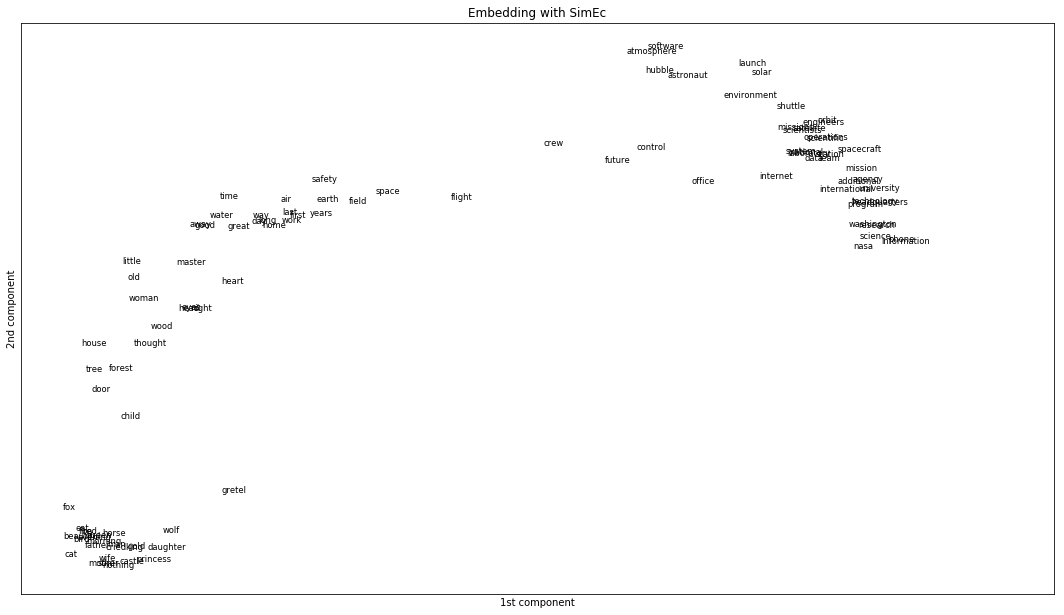

In [37]:
# train simec
X, _ = features2mat(words_dict, words_selected)
X = X.toarray()
simec = SimilarityEncoder(X.shape[1], 2, S.shape[1], hidden_layers=[(10, 'tanh')], l2_reg=0.00001, 
                          l2_reg_emb=0.0001, opt=keras.optimizers.Adamax(lr=0.03))
simec.fit(X, S, epochs=400)
X_embed = simec.transform(X)
plot_words(X_embed, words_selected, 'Embedding with SimEc')
plt.xlabel('1st component');
plt.ylabel('2nd component');
fig = plt.gcf();
fig.set_size_inches(18.5, 10.5);

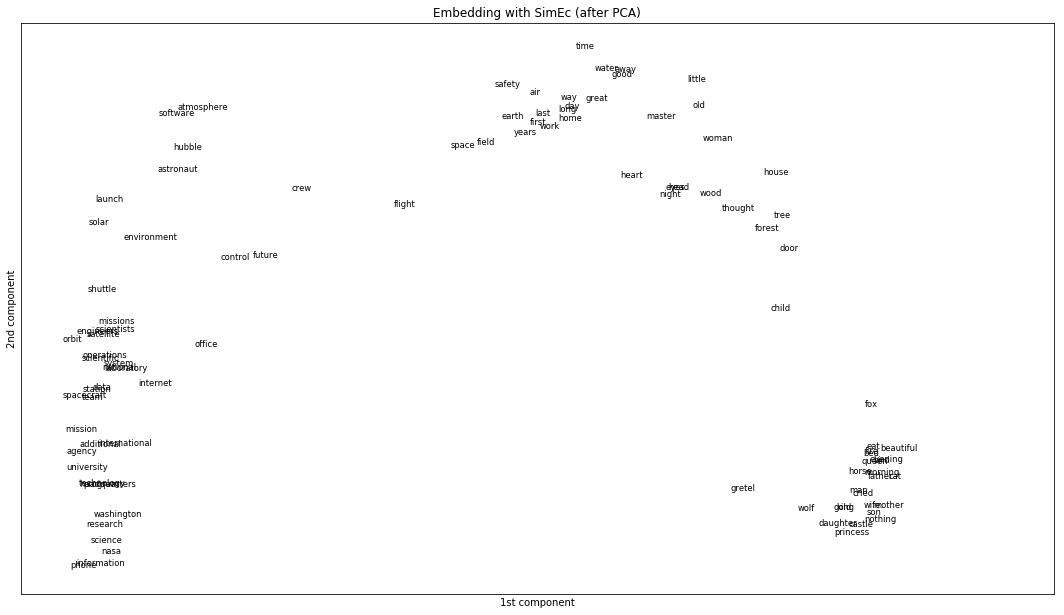

In [38]:
pca = PCA(n_components=2)
X_embed_pca = pca.fit_transform(X_embed)
plot_words(X_embed_pca, words_selected, 'Embedding with SimEc (after PCA)')
plt.xlabel('1st component');
plt.ylabel('2nd component');
fig = plt.gcf();
fig.set_size_inches(18.5, 10.5);